In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

In [2]:
d = {'Condition': ['H', 'H', 'H', 'C', 'C', 'C'],
     'Flowrate': [10, 2.5, 3, 6.25, 10, 4],
     'CP': [0.8, 0.8, 1.0, 0.8, 0.8, 1.0],
     'Tin': [300, 150, 200, 190, 90, 40],
     'Tout': [150, 50, 50, 290, 190, 190]}

data = pd.DataFrame(data=d)

In [22]:
class MNUHE():
    
    def __init__(self, rawdata, deltaT):
        self.rawdata = rawdata
        self.deltaT = deltaT
        
        self.rawdata['mCP'] = self.rawdata.Flowrate*self.rawdata.CP
        self.rawdata['Q'] = self.rawdata.mCP*(self.rawdata.Tin - self.rawdata.Tout)
        
        self.Qtotal = self.rawdata.Q.sum()
        self.nstreams = self.rawdata.shape[0]
        
    def interval_diagram(self):
        
        self.rawdata['deltaT'] = self.rawdata.Tout - self.rawdata.Tin
        
        # Temperatures in terms of hot streams
        self.rawdata['Tin_C'] = self.rawdata.Tin
        self.rawdata['Tout_C'] = self.rawdata.Tout
        self.rawdata.loc[(self.rawdata.Condition == 'H'), ['Tin_C', 'Tout_C']] += - self.deltaT
        
        # Temperatures in terms of cold streams
        self.rawdata['Tin_H'] = self.rawdata.Tin
        self.rawdata['Tout_H'] = self.rawdata.Tout
        self.rawdata.loc[(self.rawdata.Condition == 'C'), ['Tin_H', 'Tout_H']] += self.deltaT
        
        # Define temperature intervals
        self.hotintervals = np.unique(self.rawdata.loc[:, ['Tin_H', 'Tout_H']].values)[::-1]
        self.coldintervals = np.unique(self.rawdata.loc[:, ['Tin_C', 'Tout_C']].values)[::-1]
        self.nintervals = self.hotintervals.shape[0] - 1
        
        # Make plot
        fig, ax = plt.subplots(figsize=(11, 7))
        ax2 = ax.twinx()
        
        
        headl = 20
        
        Thi = np.max(self.hotintervals)
        Tlo = np.min(self.hotintervals)
        Thi2 = np.max(self.coldintervals)
        Tlo2 = np.min(self.coldintervals)

        for i in self.hotintervals:
            ax.hlines(i, 0, 7)
        
        i = 0
        while i < self.nstreams:

            if self.rawdata.Condition[i] == 'H':
                ax.arrow(i+1, self.rawdata.Tin_H[i], 0, self.rawdata.deltaT[i] + headl, width=0.25, head_width=0.5, head_length=headl, color='Red')
            else:
                ax2.arrow(i+1, self.rawdata.Tin_C[i], 0, self.rawdata.deltaT[i] - headl, width=0.25, head_width=0.5, head_length=headl, color='Blue')
            i += 1

        


        ax.set_ylim([Tlo-20, Thi+20])
        ax.set_xlim([0, self.nstreams + 1])
        ax2.set_ylim([Tlo2 - 20, Thi2+20])
        yticks = ax.get_yticks()
        ax2.set_yticks(yticks[1:-1]-self.deltaT)
        print(yticks)
        
        
    def cascade_diagram(self):
        test = self
        energy_left = []

        for i, lo in enumerate(test.hotintervals):

            if lo > np.min(test.hotintervals):
                # print('Range: {} - {}'.format(lo, test.hotintervals[i+1]))
                # Calculate the midpoint of each temperature interval
                midp = np.average([lo, test.hotintervals[i+1]])

                # Narrow down the streams that are present in each temperature interval
                short = test.rawdata.loc[((test.rawdata.Tout_H - midp)*(test.rawdata.Tin_H - midp) < 0), :]
                signs = np.vectorize({'H':-1, 'C':1}.get)(short.Condition)

                # Calculate the energy available in each temperature interval
                energy_left.append(np.sum(signs*short.mCP*(test.hotintervals[i+1] - test.hotintervals[i])))

            else:
                pass
        
        
        # Create cascade diagram
        cascade = np.cumsum(np.array(energy_left))
        fig, ax = plt.subplots(figsize=(11, 7))
        props = dict(boxstyle='round', facecolor='white', pad=0.6)
        levels = np.linspace(0.83, 0.08, test.nintervals)
        letters = string.ascii_uppercase[:test.nintervals]
        adjust = 0.05
        width = (levels[0] - levels[1])/2 - adjust

        pinchloc = np.where(cascade < 0)[0][0]
        qH = -cascade[pinchloc]
        Tpinch_H = test.hotintervals[pinchloc+1]
        Tpinch_C = test.coldintervals[pinchloc+1]

        oneup = cascade + qH
        qC = oneup[-1]

        qh_hor = levels[pinchloc] + adjust
        pinch_hor = np.average([levels[pinchloc], levels[pinchloc+1]]) + adjust

        for i, level in enumerate(energy_left):
            ax.text(0.5, levels[i], '{}\n{}'.format(letters[i], energy_left[i]), fontsize=20, horizontalalignment='center', bbox=props)

        for i, level in enumerate(cascade):
            if level < 0:
                pass
            elif i >= test.nintervals-1:
                pass
            else:
                ax.text(0.65, levels[i] - width, '{}'.format(level), fontsize=20, horizontalalignment='center')
                ax.arrow(0.5, levels[i], 0, (levels[i+1] - levels[i])/2 + 0.4*adjust, width=0.001, head_width=0.02, head_length=0.01, color='k')

        # QHot
        ax.arrow(0.15, qh_hor, 0.25, 0, width=0.001, head_width=0.02, head_length=0.01, color='k')
        ax.text(0.1, qh_hor - adjust, '{}\n{}'.format('Qh', qH), fontsize=20, horizontalalignment='center', bbox=props)

        # QCold
        ax.arrow(0.6, levels[-1] + adjust, 0.25, 0, width=0.001, head_width=0.02, head_length=0.01, color='k')
        ax.text(0.92, levels[-1], '{}\n{}'.format('Qc', qC), fontsize=20, horizontalalignment='center', bbox=props)

        # Pinch
        ax.hlines(pinch_hor, 0, 1, color='k', linestyles='--')
        ax.set_ylim([0, 1])
        ax.axis('off')
        
        self.energy_left = energy_left
        self.cascade = cascade
        self.pinchloc = pinchloc
        self.qH = qH
        self.qC = qC
        self.Tpinch_H = Tpinch_H
        self.Tpinch_C = Tpinch_C
        

In [23]:
test = MNUHE(data, 10)

-50.0


[  0.  50. 100. 150. 200. 250. 300. 350.]


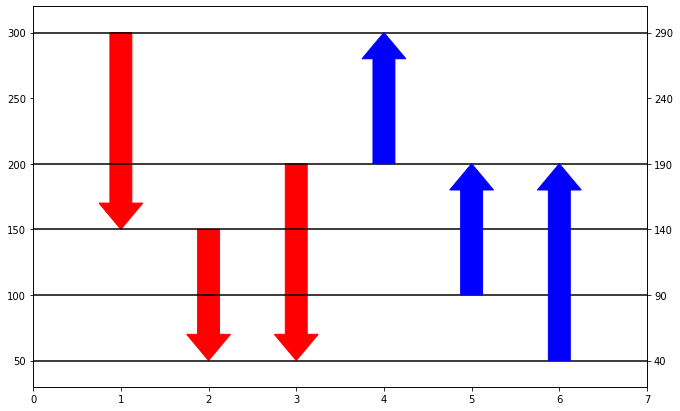

In [25]:
test.interval_diagram()

In [370]:
test.energy_left

[300.0, -50.0, -350.0, 50.0]

In [371]:
test.cascade

array([ 300.,  250., -100.,  -50.])

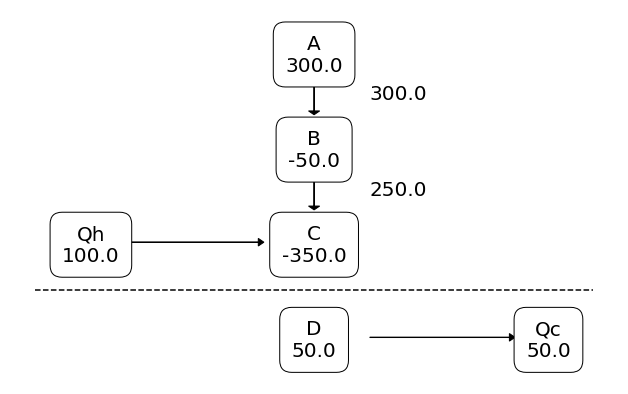

In [368]:
test.cascade_diagram()

In [418]:
test.rawdata['Qabove'] = test.rawdata.Q
test.rawdata['Qbelow'] = test.rawdata.Q

hots = test.rawdata.loc[(test.rawdata.Condition == 'H'), :]
a1 = hots.mCP*(hots.Tin_H - hots.Tout_H)
a2 = hots.mCP*(hots.Tin_H - test.Tpinch_H)
a3 = np.minimum(a1, a2)
a3[a3 < 0] = np.nan
test.rawdata.loc[(test.rawdata.Condition == 'H'), 'Qabove'] = a3

a1 = hots.mCP*(hots.Tin_H - hots.Tout_H)
a2 = hots.mCP*(test.Tpinch_H - hots.Tout_H)
a3 = np.minimum(a1, a2)
a3[a3 < 0] = np.nan
test.rawdata.loc[(test.rawdata.Condition == 'H'), 'Qbelow'] = a3

colds = test.rawdata.loc[(test.rawdata.Condition == 'C'), :]
a1 = colds.mCP*(colds.Tin_C - colds.Tout_C)
a2 = colds.mCP*(test.Tpinch_C -  colds.Tout_C)
a3 = np.maximum(a1, a2)
a3[a3 > 0] = np.nan
test.rawdata.loc[(test.rawdata.Condition == 'C'), 'Qabove'] = a3

a1 = colds.mCP*(colds.Tin_C - colds.Tout_C)
a2 = colds.mCP*(colds.Tin_C - test.Tpinch_C)
a3 = np.maximum(a1, a2)
a3[a3 > 0] = np.nan
test.rawdata.loc[(test.rawdata.Condition == 'C'), 'Qbelow'] = a3



In [419]:
test.rawdata

,Condition,Flowrate,CP,Tin,Tout,mCP,Q,deltaT,Tin_C,Tout_C,Tin_H,Tout_H,Qabove,Qbelow
0,H,10.00,0.8,300,150,8.0,1200.0,-150,290,140,300,150,1200.0,NaN
1,H,2.50,0.8,150,50,2.0,200.0,-100,140,40,150,50,100.0,100.0
2,H,3.00,1.0,200,50,3.0,450.0,-150,190,40,200,50,300.0,150.0
3,C,6.25,0.8,190,290,5.0,-500.0,100,190,290,200,300,-500.0,NaN
4,C,10.00,0.8,90,190,8.0,-800.0,100,90,190,100,200,-800.0,0.0
5,C,4.00,1.0,40,190,4.0,-600.0,150,40,190,50,200,-400.0,-200.0


In [408]:
hmm = np.maximum(a1, a2)
hmm[hmm > 0] = 0

3     True
4    False
5    False
dtype: bool

In [405]:
a1

3   -500.0
4   -800.0
5   -600.0
dtype: float64